In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras import regularizers, metrics, backend
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lib import lstm_tools
import os
import math

2023-05-16 22:21:19.558160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.path.pardir))
files_dir = os.path.join(parent_dir, 'data/VARMA_ARIMA/after_ARIMA/')

## **ARIMA input**

In [3]:
data = []
d = 0

for file in os.listdir(files_dir):
    file_path = os.path.join(files_dir, file)
    df = pd.read_csv(file_path, index_col='date', parse_dates=True)
    if not d:
        dates = df.index
        d = 1
    if np.isnan(df).any().any() or np.isnan(df).any().any() :
        print(file)
        continue
    data.append(df.reset_index(drop=True))

## **預處理：MinMax Scaler**

In [4]:
# scaler = MinMaxScaler()

## **預處理：切割資料集**

In [5]:
X, y, train_X, train_y, val_X, val_y, test_X, test_y = [],[],[],[],[],[],[],[]
past_n = 14
future_n = 1

for pair_corr in data:
    # scaler.fit(pair_corr)
    # pair_corr = scaler.transform(pair_corr)
    for i in range(past_n, len(pair_corr) - future_n + 1):
        X.append(pair_corr[i - past_n:i])
        y.append(pair_corr[i + future_n - 1:i + future_n]['close'])

In [6]:
X = np.array([X[i].values.tolist() for i in range(len(X))])
y = np.array([a.values.tolist() for a in y])

In [7]:
train_X, train_y = X[:int(len(X) * 0.7)], y[:int(len(X) * 0.7)]
val_X, val_y = X[int(len(X) * 0.7):int(len(X) * (0.7 + 0.15))], y[int(len(X) * 0.7):int(len(X) * (0.7 + 0.15))]
test_X, test_y = X[int(len(X) * (0.7 + 0.15)):], y[int(len(X) * (0.7 + 0.15)):]

In [8]:
input_shape = (train_X.shape[1], train_X.shape[2])

In [9]:
train_X.shape

(110703, 14, 8)

## **模型訓練**

In [11]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true)))

In [12]:
def build_lstm_model(x_shape, y_shape, neurons, dropout_rate, is_doubled_layer, is_regularized):
    model = Sequential()
    if is_doubled_layer:
        model.add(LSTM(neurons, input_shape=x_shape, return_sequences=True))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(int(neurons/2), input_shape=x_shape, return_sequences=True))
        model.add(Dropout(dropout_rate))
    else:
        model.add(LSTM(neurons, input_shape=x_shape))
        model.add(Dropout(dropout_rate))
    if is_regularized:
        model.add(Dense(x_shape[1], 'relu',  kernel_regularizer=regularizers.l2(0.01)))
    else:
        model.add(Dense(x_shape[1], 'relu'))
    model.add(Dense(y_shape, 'linear'))
    
    adam = Adam(lr=0.001)
    mse = MeanSquaredError()
    model.compile(optimizer=adam, loss=mse, metrics=[metrics.MSE, metrics.MAE])
    return model

## **比較模型**

In [13]:
model = build_lstm_model(input_shape, 1, 64, 0.5, 0, 1)
model.summary()

2023-05-16 21:09:52.392110: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 19,217
Trainable params: 19,217
Non-trainable params: 0
_________________________________________________________________


2023-05-16 21:09:52.734392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 21:09:52.736094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 21:09:52.737500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
checkpoint_dir = os.path.join(parent_dir, 'models/0515_Single_ARIMA.h5')
early_stopping = EarlyStopping(monitor='val_loss', patience=50)
checkpoint_callback = ModelCheckpoint(checkpoint_dir, monitor='val_loss', verbose=1, 
                                      mode='min', save_best_only=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=15, min_lr=0.0001)


In [27]:
history = model.fit(train_X, train_y, epochs=3, batch_size=128, validation_data=(val_X, val_y), callbacks=[early_stopping, checkpoint_callback, lr_reduction])

Epoch 1/3
865/865 [==============================] - ETA: 0s - loss: 0.2033 - mean_squared_error: 0.1996 - mean_absolute_error: 0.3692
Epoch 1: val_loss improved from 0.20033 to 0.20014, saving model to /home/seco/documents/VARMA-MRRNN/models/0515_Single_ARIMA.h5
865/865 [==============================] - 27s 31ms/step - loss: 0.2033 - mean_squared_error: 0.1996 - mean_absolute_error: 0.3692 - val_loss: 0.2001 - val_mean_squared_error: 0.1991 - val_mean_absolute_error: 0.3711 - lr: 0.0010
Epoch 2/3
865/865 [==============================] - ETA: 0s - loss: 0.2001 - mean_squared_error: 0.1995 - mean_absolute_error: 0.3690
Epoch 2: val_loss improved from 0.20014 to 0.19944, saving model to /home/seco/documents/VARMA-MRRNN/models/0515_Single_ARIMA.h5
865/865 [==============================] - 26s 30ms/step - loss: 0.2001 - mean_squared_error: 0.1995 - mean_absolute_error: 0.3690 - val_loss: 0.1994 - val_mean_squared_error: 0.1990 - val_mean_absolute_error: 0.3708 - lr: 0.0010
Epoch 3/3
86

In [16]:
def visialize_loss_plot(history):
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xlabel('# epochs')
    plt.ylabel('MSE')
    plt.show()

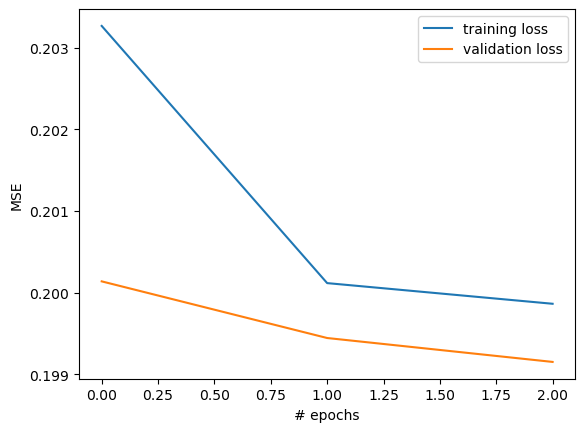

In [28]:
visialize_loss_plot(history)

In [29]:
def evaluate_model(model, train_X, train_y, val_X, val_y, test_X, test_y):
    score_train = model.evaluate(train_X, train_y)
    score_test = model.evaluate(test_X, test_y)
    score_val = model.evaluate(val_X, val_y)
    evaluate_df = pd.DataFrame(np.array([score_train[1], score_val[1], score_test[1], 
                                score_train[2], score_val[2], score_test[2]]).reshape(-1, 6),
                      columns=["train_MSE", "val_MSE", "test_MSE", "train_MAE", "val_MAE", "test_MAE"])
    return evaluate_df
    

In [31]:
best_model = load_model(os.path.join(parent_dir, 'models/0515_Single_ARIMA.h5'))

2023-05-16 21:18:39.425603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 21:18:39.427408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 21:18:39.428603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [32]:
evaluation = evaluate_model(best_model, train_X, train_y, val_X, val_y, test_X, test_y)

2023-05-16 21:18:41.556576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 21:18:41.558491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 21:18:41.559770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

742/742 [==============================] - 6s 7ms/step - loss: 0.1992 - mean_squared_error: 0.1987 - mean_absolute_error: 0.3684


## **預測**

In [4]:
tmp_dir = os.path.join(parent_dir, 'data/VARMA_ARIMA_prediction/after_ARIMA/')

In [5]:
best_model = load_model(os.path.join(parent_dir, 'models/0515_VARMA_64_0_1.h5'))

2023-05-16 22:21:31.531011: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-05-16 22:21:31.869802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-16 22:21:31.871459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-16 22:21:31.8

In [45]:
past_n = 14
future_n = 1
mae, mse = [], []
count = 0


In [46]:
tmp_dir = os.path.join(parent_dir, 'data/VARMA_ARIMA_prediction/after_ARIMA/')
hybrid_prediction_mse, hybrid_prediction_mae, arima_prediction_mae, arima_prediction_mse = [], [], [], []
for file in os.listdir(tmp_dir):
    if count != 0:
        break
    count = count + 1
    residual_file_path = os.path.join(files_dir, file)
    residual_df = pd.read_csv(residual_file_path, index_col='date', parse_dates=True)
    residual_df = residual_df.reset_index(drop=True)
    arima_output_path = os.path.join(parent_dir, f'data/VARMA_ARIMA_prediction/after_ARIMA/{file}')
    arima_output_df = pd.read_csv(arima_output_path, index_col='date', parse_dates=True)
    arima_output_df = arima_output_df.reset_index(drop=True)
    arima_output_df = arima_output_df['close']
    original_path = os.path.join(parent_dir, f'data/preprocessed_data/{file}')
    original_df = pd.read_csv(original_path, index_col='date', parse_dates=True)
    timestamps = original_df.index
    original_df = original_df.reset_index(drop=True)
    original_df = original_df['close']
    original_df = original_df[-len(arima_output_df):]
    
    residual_X, arima_prediction, original, lstm_predict = [], [], [], []
    for i in range(past_n, len(residual_df) - future_n + 1):
        residual_X.append(residual_df[i - past_n:i])
    residual_X = np.array([residual_X[i].values.tolist() for i in range(len(residual_X))])
    predictions_df = best_model.predict(residual_X)
    for i in range(len(predictions_df)):
        lstm_predict.append(predictions_df[i][0])
    
    arima_prediction = arima_output_df[-len(lstm_predict):].tolist()
    original = original_df[-len(lstm_predict):].tolist()
    timestamps = timestamps[-len(lstm_predict):].tolist()
    hybrid_prediction = [x - y for x, y in zip(arima_prediction, lstm_predict)]
    
    arima_prediction_mse.append(mean_squared_error(original, arima_prediction))
    arima_prediction_mae.append(mean_absolute_error(original, arima_prediction))
    hybrid_prediction_mse.append(mean_squared_error(original, hybrid_prediction))
    hybrid_prediction_mae.append(mean_absolute_error(original, hybrid_prediction))

5/5 [==============================] - 0s 8ms/step


In [42]:
df_error = pd.DataFrame(columns=['ARIMA prediction MSE', 'ARIMA prediction MAE', 'ARIMA_LSTM prediction MSE', 'ARIMA_LSTM prediction MAE'])
df_error.loc[0] = lstm_tools.mean(arima_prediction_mse), lstm_tools.mean(arima_prediction_mae), lstm_tools.mean(hybrid_prediction_mse), lstm_tools.mean(hybrid_prediction_mae)

AttributeError: module 'lib.lstm_tools' has no attribute 'mean'

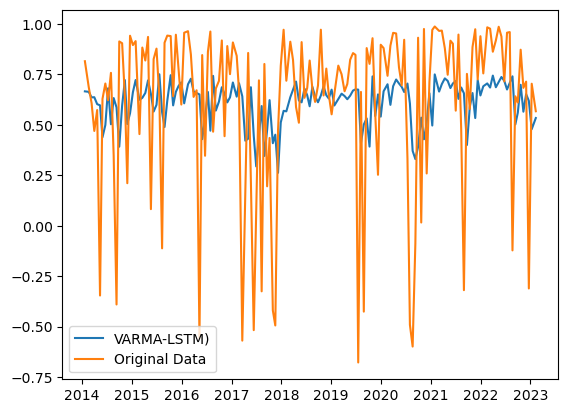

In [53]:
plt.plot(timestamps, hybrid_prediction, label= f'VARMA-LSTM)')
plt.plot(timestamps,original, label='Original Data')
plt.legend()

In [50]:
timestamps

[Timestamp('2014-01-21 00:00:00'),
 Timestamp('2014-02-18 00:00:00'),
 Timestamp('2014-03-11 00:00:00'),
 Timestamp('2014-03-31 00:00:00'),
 Timestamp('2014-04-21 00:00:00'),
 Timestamp('2014-05-12 00:00:00'),
 Timestamp('2014-05-30 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-10 00:00:00'),
 Timestamp('2014-07-31 00:00:00'),
 Timestamp('2014-08-20 00:00:00'),
 Timestamp('2014-09-10 00:00:00'),
 Timestamp('2014-09-30 00:00:00'),
 Timestamp('2014-10-21 00:00:00'),
 Timestamp('2014-11-10 00:00:00'),
 Timestamp('2014-11-28 00:00:00'),
 Timestamp('2014-12-18 00:00:00'),
 Timestamp('2015-01-08 00:00:00'),
 Timestamp('2015-01-28 00:00:00'),
 Timestamp('2015-02-25 00:00:00'),
 Timestamp('2015-03-18 00:00:00'),
 Timestamp('2015-04-09 00:00:00'),
 Timestamp('2015-04-29 00:00:00'),
 Timestamp('2015-05-20 00:00:00'),
 Timestamp('2015-06-09 00:00:00'),
 Timestamp('2015-06-30 00:00:00'),
 Timestamp('2015-07-21 00:00:00'),
 Timestamp('2015-08-10 00:00:00'),
 Timestamp('2015-08-